In [1]:
#https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical CPU, 1 Logical CPU


In [2]:
import tensorflow as tf
import numpy as np
import cv2
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import imutils

In [3]:
# initialize the model to be VGG16
#Model = VGG16

In [4]:
# check to see if we are using ResNet
Model = ResNet50

In [5]:
# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet", include_top=True)

[INFO] loading model...


In [6]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

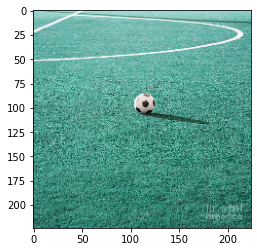

In [7]:
# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
import zipfile
zf = zipfile.ZipFile('grad_cam_images.zip')
#orig = cv2.imread(os.path.join('grad_cam_images', 'soccer_ball.jpg'))
orig = cv2.imdecode(np.frombuffer(zf.read('soccer_ball.jpg'), np.uint8), 1)
resized = cv2.resize(orig, (224, 224))
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(resized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


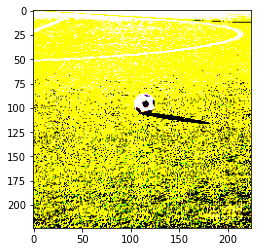

In [13]:
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
import zipfile
zf = zipfile.ZipFile('grad_cam_images.zip')
#orig = cv2.imread(os.path.join('grad_cam_images', 'soccer_ball.jpg'))
image = cv2.imdecode(np.frombuffer(zf.read('soccer_ball.jpg'), np.uint8), 1)
image = cv2.resize(image, (224, 224))
#image = load_img(os.path.join('grad_cam_images', 'soccer_ball.jpg'), target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)
from matplotlib import pyplot as plt
plt.imshow(image[0])

In [14]:
# use the network to make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

In [15]:
print(preds[0][:5])
print(i)

[2.8029391e-12 2.8265884e-12 3.3927050e-10 9.6567815e-12 5.3350699e-11]
805


In [16]:
# decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

[INFO] soccer_ball: 99.94%


In [17]:
from tensorflow.keras.models import Model
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name

		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		#gradModel = Model(inputs=[self.model.inputs],outputs=[self.model.get_layer(self.layerName).output,self.model.output])
		#bug patch: Namshin Kim. June 26, 2020.
		gradModel = Model(self.model.inputs, [self.model.get_layer(self.layerName).output, self.model.output])

		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

In [18]:
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

In [19]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [20]:
# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [126, 114, 133],
        [124, 112, 132],
        [122, 112, 130]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [125, 114, 132],
        [124, 113, 132],
        [124, 113, 132]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [128, 114, 134],
        [129, 115, 134],
        [130, 116, 135]],

       ...,

       [[ 58,  56,  80],
        [ 58,  55,  80],
        [ 60,  55,  80],
        ...,
        [ 80,  74,  98],
        [ 72,  67,  90],
        [ 72,  65,  88]],

       [[ 58,  53,  78],
        [ 55,  48,  74],
        [ 53,  46,  71],
        ...,
        [ 78,  73,  96],
        [ 74,  68,  92],
        [ 74,  68,  90]],

       [[ 62,  54,  80],
        [ 56,  47,  72],
        [ 50,  41,  66],
        ...,
        [ 76,  71,  94],
        [ 70,  65,  88],
        [ 70,  64,  86]]

In [21]:
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2.imshow("Output", output)
cv2.waitKey(0)

-1